# Analyze escape profiles for antibodies
This Python Jupyter notebook plots escape profiles for antibodies.

## Set up analysis
Import Python modules:

In [1]:
import os

import Bio.SeqIO

import dms_variants
import dms_variants.constants
import dms_variants.utils

import dmslogo
from dmslogo.colorschemes import CBPALETTE

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import pdb_prot_align.colorschemes

import yaml

Versions of key software:

In [2]:
print(f"Using `dmslogo` version {dmslogo.__version__}")
print(f"Using `dms_variants` version {dms_variants.__version__}")

Using `dmslogo` version 0.4.0
Using `dms_variants` version 0.8.4


Read the configuration file:

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [4]:
os.makedirs(config['escape_profiles_dir'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [5]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_epistasis_model
At mutation level, quantify selection by mut_escape_frac_epistasis_model


## Read samples and escape fractions
Read the escape fractions.
We only retain the **average** of the libraries for plotting here, not the individual libraries.
Also, we work in the full-Spike rather than RBD numbering, which means we use `label_site` as `site` (and so rename as such below):

In [6]:
print(f"Reading escape fractions from {config['escape_fracs']}")
escape_fracs = (pd.read_csv(config['escape_fracs'])
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame with sample-information added:')
display(HTML(escape_fracs.head().to_html(index=False)))

Reading escape fractions from results/escape_scores/escape_fracs.csv
First few lines of escape-fraction data frame with sample-information added:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
2B04_400,331,N,A,E,331,0.001161,0.000603,0.05265,0.06513,0.002771,0.003428,2
2B04_400,331,N,C,E,331,0.001007,0.002096,0.05265,0.06513,0.002771,0.003428,2
2B04_400,331,N,D,E,331,0.001007,0.001018,0.05265,0.06513,0.002771,0.003428,2
2B04_400,331,N,E,E,331,0.001067,0.001079,0.05265,0.06513,0.002771,0.003428,2
2B04_400,331,N,F,E,331,0.003066,0.001223,0.05265,0.06513,0.002771,0.003428,2


## Auto-identify sites of strong selection
First we automatically identify sites of "strong" selection.

We do this using two criteria:

 - The selection at a site has to exceed the median selection across all sites for that condition (e.g., antibody or sera) by some threshold.
 
 - The selection at a site has to be at least some fraction of the maximum selection observed at any site for that condition (e.g., antibody or sera).
 
First, we do these computations with several different thresholds for these criteria to see how many sites we identify:

In [7]:
median_thresholds = [5, 10, 20]
median_threshold_names = [f"{threshold}X median" for threshold in median_thresholds]

fracmax_thresholds = [0.05, 0.1, 0.2]
fracmax_threshold_names = [f"{threshold}X max" for threshold in fracmax_thresholds]

# get median and max site metric for each condition
site_metric_df = (
    escape_fracs
    [['condition', 'site', site_metric]]
    .drop_duplicates()
    .assign(median=lambda x: x.groupby('condition')[site_metric].transform('median'),
            max=lambda x: x.groupby('condition')[site_metric].transform('max'))
    )

# at each threshold, flag sites > thresholds
site_threshold_df = (
    pd.concat([
        site_metric_df.assign(
                median_threshold_name=median_threshold_name,
                median_threshold=lambda x: x['median'] * median_threshold,
                above_median_threshold=lambda x: x[site_metric] > x['median_threshold'],
                fracmax_threshold_name=fracmax_threshold_name,
                fracmax_threshold=lambda x: x['max'] * fracmax_threshold,
                above_fracmax_threshold=lambda x: x[site_metric] > x['fracmax_threshold'],
                above_threshold=lambda x: x['above_median_threshold'] & x['above_fracmax_threshold'],
                )
        for median_threshold, median_threshold_name in zip(median_thresholds, median_threshold_names)
        for fracmax_threshold, fracmax_threshold_name in zip(fracmax_thresholds, fracmax_threshold_names)
        ])
    .assign(median_threshold_name=lambda x: pd.Categorical(x['median_threshold_name'],
                                                           median_threshold_names,
                                                           ordered=True),
            fracmax_threshold_name=lambda x: pd.Categorical(x['fracmax_threshold_name'],
                                                            fracmax_threshold_names,
                                                            ordered=True),
            n_above_threshold=lambda x: x.groupby(['condition', 'median_threshold_name', 'fracmax_threshold_name'])
                                         ['above_threshold']
                                         .transform('sum')
                                         .astype(int)
            )
    )

Now plot the distribution of site selection, indicating how many sites exceed the threshold for each condition (e.g., antibody or sera):

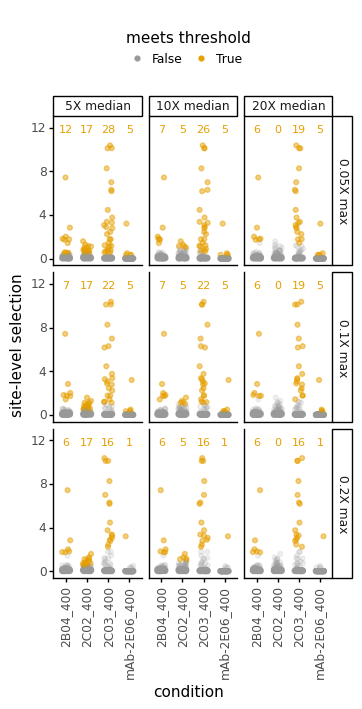

In [8]:
max_y = site_threshold_df[site_metric].max()  # max y-value plotted

p = (ggplot(site_threshold_df.assign(alpha=lambda x: x['above_threshold'].astype(int))
            ) +
     aes('condition', site_metric, color='above_threshold', alpha='alpha') +
     geom_jitter(size=1.5, height=0, width=0.2, stroke=0.5) +
     facet_grid('fracmax_threshold_name ~ median_threshold_name') +
     scale_color_manual(values=CBPALETTE,
                        name='meets threshold') +
     scale_alpha(range=(0.15, 0.5), guide=None) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.3 * site_threshold_df['condition'].nunique() * site_threshold_df['median_threshold_name'].nunique(),
                        2 * site_threshold_df['fracmax_threshold_name'].nunique()),
           legend_position='top',
           ) +
     ylab('site-level selection') +
     expand_limits(y=1.2 * max_y) +
     geom_text(data=site_threshold_df
                    [['condition', 'median_threshold_name', 'fracmax_threshold_name', 'n_above_threshold']]
                    .drop_duplicates(),
               mapping=aes(x='condition', label='n_above_threshold'),
               y=1.1 * max_y,
               color=CBPALETTE[1],
               alpha=1,
               size=8,
               va='bottom'
               )
     )

_ = p.draw()

Based on the above plots, choose the thresholds for being above the median and fraction of the max for auto-identified sites:

In [9]:
median_threshold_to_use = '10X median'
assert median_threshold_to_use in median_threshold_names
fracmax_threshold_to_use = '0.1X max'
assert fracmax_threshold_to_use in fracmax_threshold_names

auto_identified_sites = (
    site_threshold_df
    .query('median_threshold_name == @median_threshold_to_use')
    .query('fracmax_threshold_name == @fracmax_threshold_to_use')
    .query('above_threshold')
    [['condition', 'site']]
    .drop_duplicates()
    .reset_index(drop=True)
    )

print(f"Overall auto-identified {auto_identified_sites['site'].nunique()} sites.\n"
      'Here are the first few:')

display(HTML(auto_identified_sites.head().to_html()))

auto_identified_sites.to_csv(config['significant_escape_sites'], index=False)

Overall auto-identified 32 sites.
Here are the first few:


,condition,site
0,2B04_400,361
1,2B04_400,472
2,2B04_400,484
3,2B04_400,485
4,2B04_400,486


Plot which sites are auto-identified for each condition (e.g., antibody or sera):

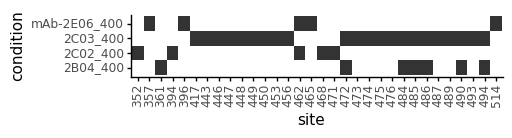

In [10]:
p = (ggplot(auto_identified_sites
            .assign(site=lambda x: pd.Categorical(x['site'],  # categorical so only plot observed sites
                                                  sorted(x['site'].unique()),
                                                  ordered=True)
                    )
            ) +
     aes('site', 'condition') +
     geom_tile() +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.15 * auto_identified_sites['site'].nunique(),
                        0.2 * auto_identified_sites['condition'].nunique()),
           )
     )

_ = p.draw()

Some sites / mutations are totally missing in the `escape_fracs` data frame.
For plotting with `dmslogo`, we need to pad these missing sites to be zero:

In [11]:
# make "padding" data frame covering all conditions, sites, and mutations
first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()
mutations = escape_fracs['mutation'].unique()
pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': site,
                                  'mutation': mutations})
                    for condition in escape_fracs['condition'].unique()
                    for site in range(first_site, last_site + 1)])

# need to read in wildtype and map site to wildtype
wt_prot = str(Bio.SeqIO.read(config['wildtype_sequence'], 'fasta').seq.translate())
assert len(wt_prot) == last_site - first_site + 1
site_to_wt = {site: wt_prot[site - first_site] for site in range(first_site, last_site + 1)}
for site, wt in escape_fracs.set_index('site')['wildtype'].to_dict().items():
    if wt != site_to_wt[site]:
        raise ValueError(site, wt, site_to_wt[site])

# pad escape fracs data frame
escape_fracs_padded = (
    escape_fracs
    [['condition', 'site', 'mutation', site_metric, mut_metric]]
    .merge(pad_df, how='outer')
    .fillna(0)
    .assign(wildtype=lambda x: x['site'].map(site_to_wt),
            wt_site=lambda x: x['wildtype'] + x['site'].astype(str))
    .assign(**{site_metric: lambda x: x.groupby(['condition', 'site'])[site_metric].transform('max')})
    )

## Add column to color by deep mutational scanning data
We add columns to the data frame that enable coloring of the logo plots by the deep mutational scanning measurements of binding or expression.
We choose a color scheme that spans the min and maximum values for all letters with non-zero height (the mutation-level metric > 0).
We also write out the scale bar for this coloring.

Importantly, **note that as long as `clip_vals_gt_0` is set to `True`, then all DMS values greater than 0 (beneficial mutations) are set to zero**. For publications, the scale bar should be manually edited to change "0" to ">0" to reflect this fact.

Reading DMS data from results/prior_DMS_data/mutant_ACE2binding_expression.csv

bind ranges from -2.33 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/bind_scalebar.pdf


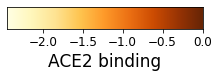

Saving DMS color scheme to results/escape_profiles/escape_profiles_dms_colors.csv

expr ranges from -1.5 to 0.0, here is the scale bar, which is being saved to results/escape_profiles/expr_scalebar.pdf


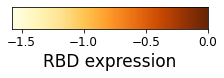

Saving DMS color scheme to results/escape_profiles/escape_profiles_dms_colors.csv


In [12]:
clip_vals_gt_0 = True  # plot DMS values > 0 as 0 (grouping beneficial and neutral)

print(f"Reading DMS data from {config['mut_bind_expr']}")

# read DMS data flagging mutations with escape > 0
mut_bind_expr = (
    pd.read_csv(config['mut_bind_expr'])
    [['site_SARS2', 'mutant', 'bind_avg', 'expr_avg']]
    .rename(columns={'site_SARS2': 'site',
                     'mutant': 'mutation',
                     'bind_avg': 'bind',
                     'expr_avg': 'expr'})
    # flag mutations with mutation escape > 0
    .merge(escape_fracs_padded, how='right', validate='one_to_many', on=['site', 'mutation'])
    .assign(escape_gt_0=lambda x: x[mut_metric] > 0)
    .groupby(['site', 'mutation', 'bind', 'expr'])
    .aggregate(escape_gt_0=pd.NamedAgg('escape_gt_0', 'any'))
    .reset_index()
    .drop_duplicates()
    )

# add color for each mutation, coloring those without escape > 0 as white
for prop in ['bind', 'expr']:
    
    # set up color scale and draw scale bard
    min_prop = mut_bind_expr.query('escape_gt_0')[prop].min()
    if clip_vals_gt_0:
        mut_bind_expr[prop] = numpy.clip(mut_bind_expr[prop], None, 0)
    max_prop = mut_bind_expr.query('escape_gt_0')[prop].max()
    colormap = pdb_prot_align.colorschemes.ValueToColorMap(
                    minvalue=min_prop - 0.05 * (max_prop - min_prop),  # move min down a bit so no letters too faint
                    maxvalue=max_prop,
                    cmap='YlOrBr',  # color map taken from here: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
                    )
    scalebar_file = os.path.join(config['escape_profiles_dir'], f"{prop}_scalebar.pdf")
    print(f"\n{prop} ranges from {min_prop} to {max_prop}, here is the scale bar, which is being saved to {scalebar_file}")
    fig, _ = colormap.scale_bar(orientation='horizontal',
                                label={'bind': 'ACE2 binding',
                                       'expr': 'RBD expression'}[prop])
    fig.savefig(scalebar_file, bbox_inches='tight')
    display(fig)
    plt.close(fig)
    
    # add color to data frame of DMS data
    mut_bind_expr[f"{prop}_color"] = mut_bind_expr.apply(lambda r: colormap.val_to_color(r[prop]) if r['escape_gt_0'] else 'white',
                                                         axis=1)
    
    # save to file the color scheme
    print(f"Saving DMS color scheme to {config['escape_profiles_dms_colors']}")
    (mut_bind_expr
     .query('escape_gt_0')
     .drop(columns='escape_gt_0')
     .to_csv(config['escape_profiles_dms_colors'], index=False)
     )
    
# add DMS coloring to escape fractions data frame
escape_fracs_padded = (
    escape_fracs_padded
    .drop(columns=['bind_color', 'expr_color'], errors='ignore')
    .merge(mut_bind_expr[['site', 'mutation', 'bind_color', 'expr_color']],
           how='left',
           validate='many_to_one',
           on=['site', 'mutation'])
    )

## Make manually specified escape profiles
We have manually specified configurations for escape profiles in a YAML file:

In [13]:
print(f"Reading escape-profile configuration from {config['escape_profiles_config']}")
with open(config['escape_profiles_config']) as f:
    escape_profiles_config = yaml.safe_load(f)
    
print(f"Reading the site color schemes from {config['site_color_schemes']}")
site_color_schemes = pd.read_csv(config['site_color_schemes'])

Reading escape-profile configuration from data/escape_profiles_config.yaml
Reading the site color schemes from data/site_color_schemes.csv


Now start making these plots:


Making plot Ellebedy_invivo, which has the following configuration specs:
{'conditions': {'2B04_400': '2B04', '2C02_400': '2C02', '2C03_400': '2C03', 'mAb-2E06_400': '2E06'}, 'plot_auto_identified_sites': True, 'add_sites': [], 'exclude_sites': [], 'site_color_scheme': 'subdomain', 'make_supp_data': True, 'color_by_dms': True}


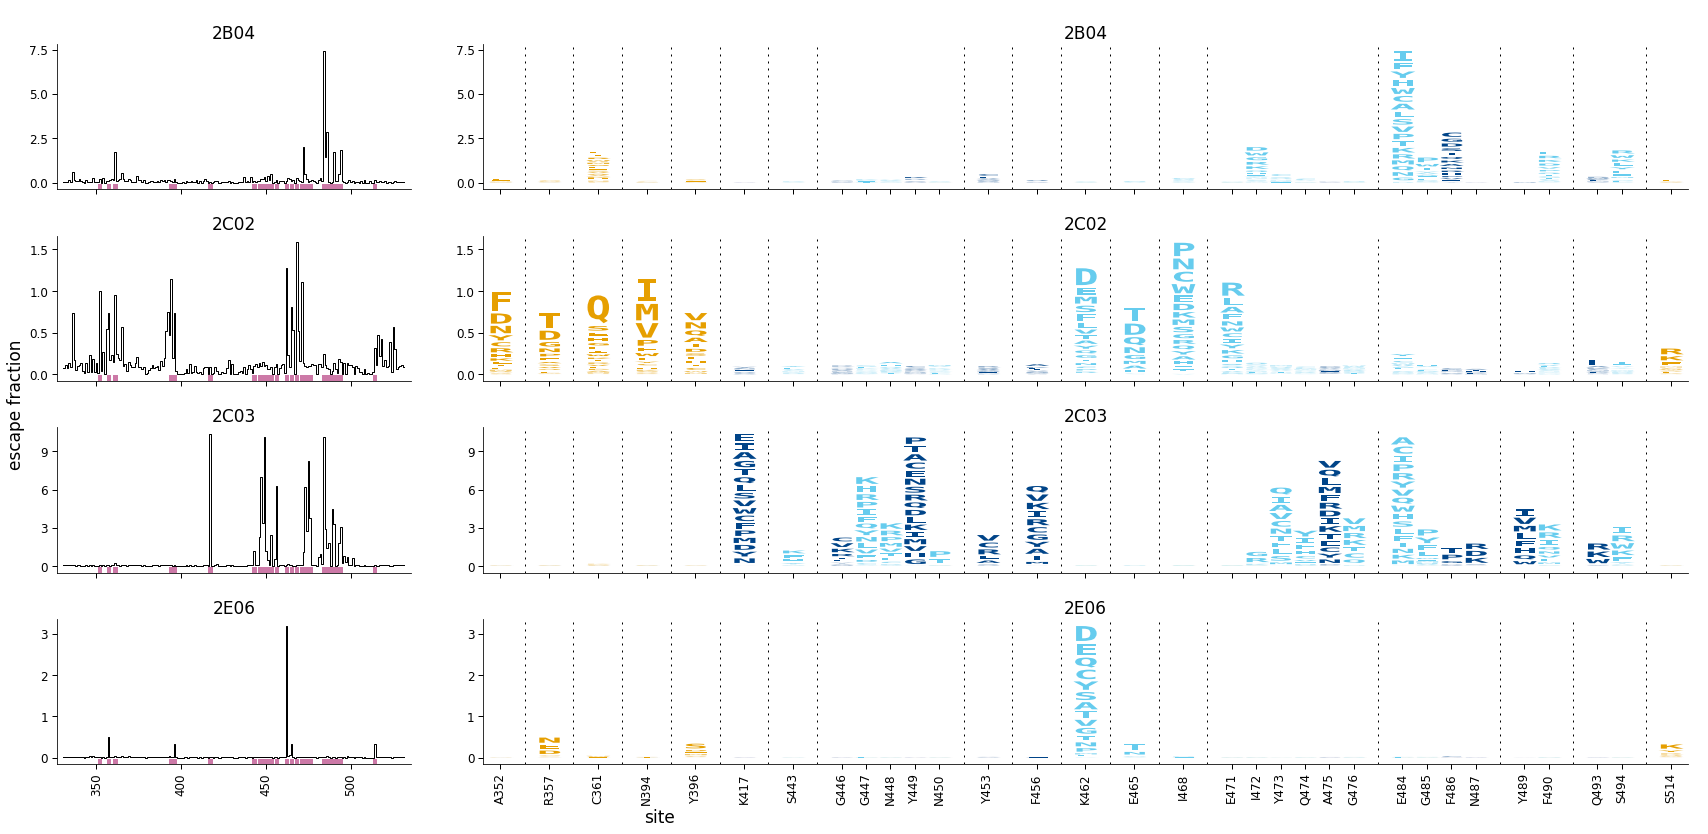

Saving to results/escape_profiles/Ellebedy_invivo_stackedlogo.pdf


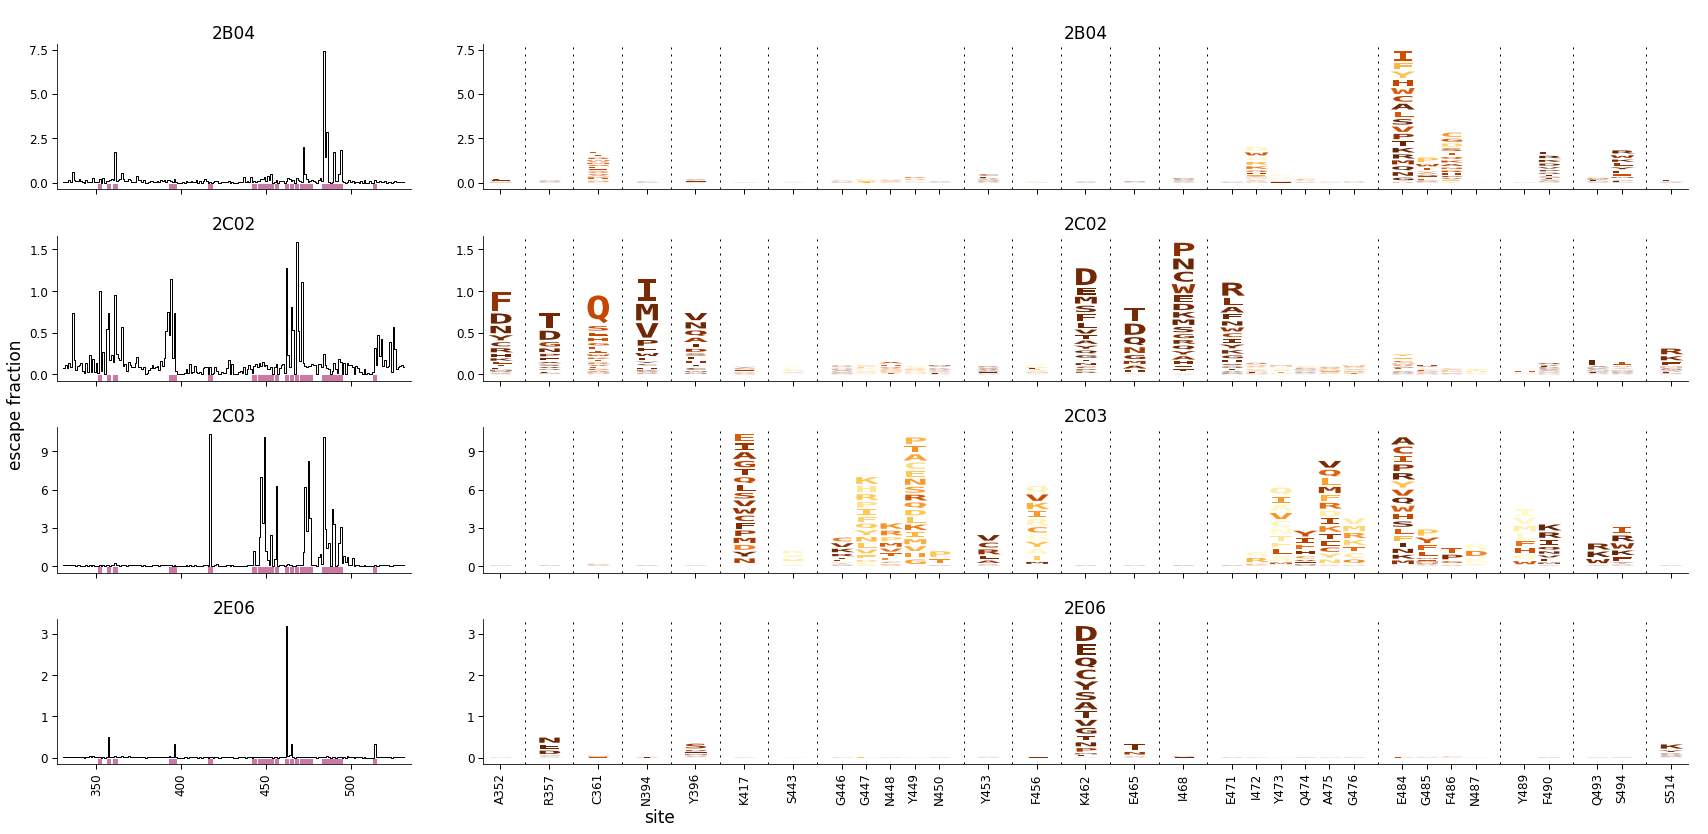

Saving to results/escape_profiles/Ellebedy_invivo_color_by_bind_stackedlogo.pdf


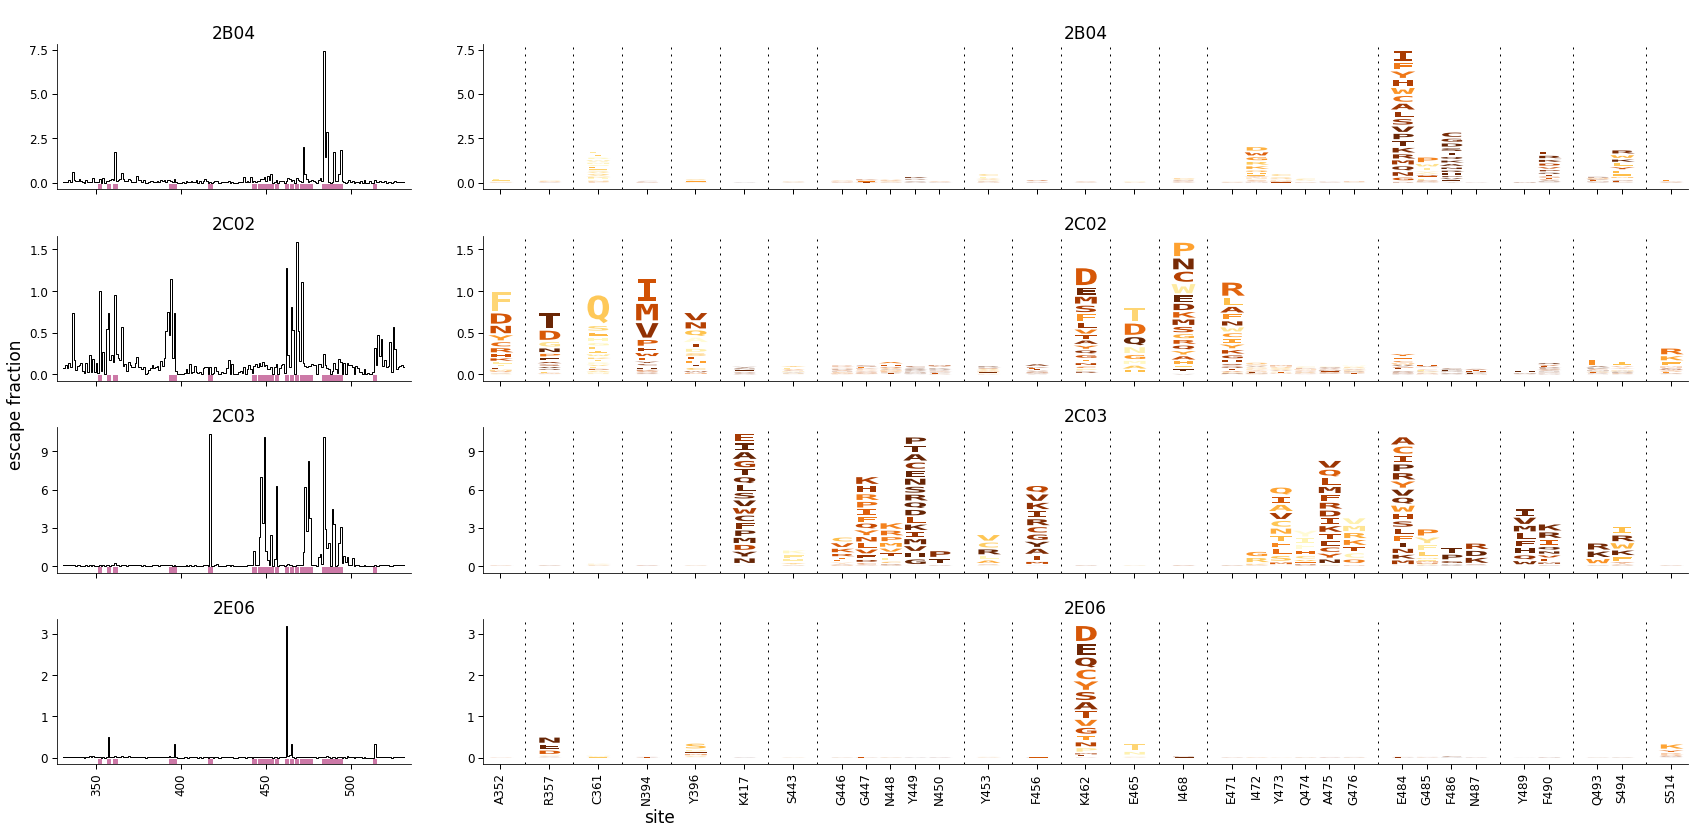

Saving to results/escape_profiles/Ellebedy_invivo_color_by_expr_stackedlogo.pdf


In [14]:
for name, specs in escape_profiles_config.items():
    
    print(f"\nMaking plot {name}, which has the following configuration specs:\n{specs}")
    
    # get data frame with just the conditions we want to plot, also re-naming them
    conditions_to_plot = list(specs['conditions'].keys())
    assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
    assert set(conditions_to_plot).issubset(set(escape_fracs_padded['condition']))
    df = (escape_fracs_padded
          .query('condition in @conditions_to_plot')
          .assign(condition=lambda x: x['condition'].map(specs['conditions']))
          )
    
    # see if we are only plotting single-nt available mutations
    if 'single_nt_only' in specs:
        print(f"Only including single-nucleotide mutations from {specs['single_nt_only']}")
        nt_seq = str(Bio.SeqIO.read(specs['single_nt_only'], 'genbank').seq)
        df = (
            df
            .assign(codon=lambda x: x['site'].map(lambda r: nt_seq[3 * (r - 1): 3 * r]),
                    codon_aa=lambda x: x['codon'].map(dms_variants.constants.CODON_TO_AA),
                    single_nt_accessible=lambda x: x.apply(
                                lambda row: dms_variants.utils.single_nt_accessible(row['codon'],
                                                                                    row['mutation'],
                                                                                    'false'),
                                axis=1)
                    )
            )
        if any(df['wildtype'] != df['codon_aa']):
            raise ValueError('nucleotide sequence differs DMS RBD amino-acid sequence')    
        df = df.query('single_nt_accessible')
    
    # specify order to plot
    df = df.assign(condition=lambda x: pd.Categorical(x['condition'], specs['conditions'].values(), ordered=True))
    
    # get the sites we want to show in logo plots
    sites_to_show = []
    if specs['plot_auto_identified_sites']:
        sites_to_show += (auto_identified_sites
                          .query('condition in @conditions_to_plot')
                          ['site']
                          .unique()
                          .tolist()
                          )
    sites_to_show += specs['add_sites']
    sites_to_show = set(sites_to_show) - set(specs['exclude_sites'])
    df = df.assign(to_show=lambda x: x['site'].isin(sites_to_show))
    
    # is there a site color scheme?
    color_col = None
    if 'site_color_scheme' in specs:
        color_col = 'color'
        if specs['site_color_scheme'] in site_color_schemes.columns:
            # color scheme specified by site
            site_colors = site_color_schemes.set_index('site')[specs['site_color_scheme']].to_dict()
            df = df.assign(color=lambda x: x['site'].map(site_colors))
        else:
            # color specified for all sites
            df = df.assign(color=specs['site_color_scheme'])
    # is there a mutation color specification?
    if 'mutation_colors' in specs:
        assert 'site_color_scheme' in specs, 'must specify site-color scheme for mutation colors'
        print(specs['mutation_colors'])
        def mut_color(row):
            key = f"{row['mutation']}{row['site']}"
            if key in specs['mutation_colors']:
                return specs['mutation_colors'][key]
            else:
                return row[color_col]
        df = df.assign(color=lambda x: x.apply(mut_color, axis=1))
    
    # get any additional logo plot arguments
    if 'dmslogo_facet_plot_kwargs' in specs:
        dmslogo_facet_plot_kwargs = specs['dmslogo_facet_plot_kwargs']
    else:
        dmslogo_facet_plot_kwargs = {}
        
    # draw plot for each color scheme
    colors_plotfiles = [(color_col, os.path.join(config['escape_profiles_dir'], f"{name}_stackedlogo.pdf"))]
    if 'color_by_dms' in specs and specs['color_by_dms']:
        colors_plotfiles += [('bind_color', os.path.join(config['escape_profiles_dir'], f"{name}_color_by_bind_stackedlogo.pdf")),
                             ('expr_color', os.path.join(config['escape_profiles_dir'], f"{name}_color_by_expr_stackedlogo.pdf"))]
    for color, plotfile in colors_plotfiles:
        fig, ax = dmslogo.facet_plot(
            data=df,
            x_col='site',
            show_col='to_show',
            gridrow_col='condition',
            share_ylim_across_rows=False,
            draw_line_kwargs=({'height_col': site_metric,
                               'ylabel': 'escape fraction',
                               'widthscale': 1.3,
                               'show_color': CBPALETTE[-1]}
                              if 'draw_line_plot' not in specs or specs['draw_line_plot']
                              else None
                              ),
            draw_logo_kwargs={'letter_height_col': mut_metric,
                              'letter_col': 'mutation',
                              'ylabel': 'escape fraction',
                              'color_col': color,
                              'xtick_col': 'wt_site',
                              'xlabel': 'site'},
            share_xlabel=True,
            share_ylabel=True,
            **dmslogo_facet_plot_kwargs,
            )
        display(fig)
        print(f"Saving to {plotfile}")
        fig.savefig(plotfile, dpi=450, transparent=True, bbox_inches='tight')
        plt.close(fig)